# Тематическая классификация длинных текстов - PMI и LogReg

In [ ]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

In [ ]:
!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
import sys; sys.path.append('./stepik-dl-nlp')

fatal: destination path 'stepik-dl-nlp' already exists and is not an empty directory.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import collections

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils
from dlnlputils.data import tokenize_text_simple_regex, tokenize_corpus, build_vocabulary, \
    vectorize_texts, SparseFeaturesDataset
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed

init_random_seed()

## Предобработка текстов и подготовка признаков

In [ ]:
train_source = fetch_20newsgroups(subset='train')
test_source = fetch_20newsgroups(subset='test')

print('Количество обучающих текстов', len(train_source['data']))
print('Количество тестовых текстов', len(test_source['data']))
print()
print(train_source['data'][0].strip())

print()
print('Метка', train_source['target'][0])

Количество обучающих текстов 11314
Количество тестовых текстов 7532

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----

Метка 7


### Подготовка признаков

Добавил лемматизацию с использованием WordNetLemmatizer из библиотеки nltk, это позволит приводить слова к их нормальной форме. Это действие улучшит обработку текстов, убирая различия между словами одной основы. При этом смысл текста останется понятным, поскольку лемма отражает базовое значение текста.

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
# Инициализация лемматизатора
lemmatizer = WordNetLemmatizer()

# Функция для лемматизации токенов
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# Обновленная функция токенизации с обработкой токенов
def tokenize_and_process_texts(texts, process_fn=None):
    tokenized = tokenize_corpus(texts)
    if process_fn:
        tokenized = [process_fn(tokens) for tokens in tokenized]
    return tokenized

# Пример применения лемматизации к данным
train_tokenized = tokenize_and_process_texts(train_source['data'], process_fn=lemmatize_tokens)
test_tokenized = tokenize_and_process_texts(test_source['data'], process_fn=lemmatize_tokens)


print(' '.join(train_tokenized[0]))

from lerxst where thing subject what this nntp posting host rac3 organization university maryland college park line wondering anyone there could enlighten this other door sport looked from late early called bricklin door were really small addition front bumper separate from rest body this know anyone tellme model name engine spec year production where this made history whatever info have this funky looking please mail thanks brought your neighborhood lerxst


In [ ]:
MAX_DF = 0.8
MIN_COUNT = 5
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
UNIQUE_WORDS_N = len(vocabulary)
print('Количество уникальных токенов', UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10])

Количество уникальных токенов 19582
[('that', 0), ('this', 1), ('have', 2), ('with', 3), ('writes', 4), ('article', 5), ('posting', 6), ('host', 7), ('nntp', 8), ('there', 9)]


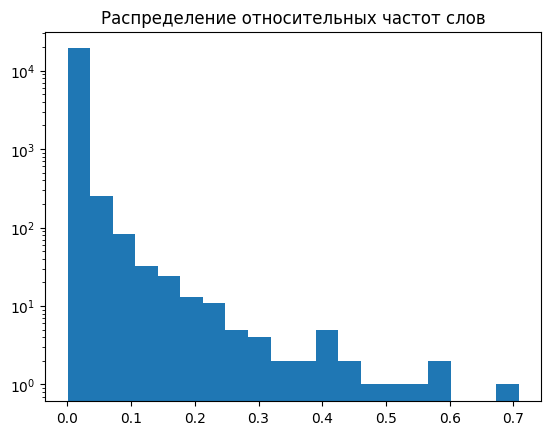

In [ ]:
plt.hist(word_doc_freq, bins=20)
plt.title('Распределение относительных частот слов')
plt.yscale('log');

Изменил начальный подход TF-IDF на CountVectorizer - этот инструмент используется для преобразования текстовых данных в векторы признаков, он работает несколько проще TF-IDF:

1.Создает словарь уникальных слов из всех текстов
2.Преобразует каждый документ в вектор, где значение элемента - это кол-во вхождений соответствующего слова в этом документе

Также он поддерживает создание n-грамм, в нашем случае я считываю лишь до биграмм, то есть последовательность из максимум 2-х слов, чтобы сильно не увеличивать объем получаемого словаря.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
import numpy as np

# Считаем частоты слов и биграмм
vectorizer = CountVectorizer(tokenizer=tokenize_text_simple_regex, ngram_range=(1, 2), max_df=MAX_DF, min_df=MIN_COUNT)
train_vectors = vectorizer.fit_transform(train_source['data'])
test_vectors = vectorizer.transform(test_source['data'])

# Выводим размерность матрицы признаков
print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print('Размерность матрицы признаков тестовой выборки', test_vectors.shape)
print()

# Выводим количество ненулевых элементов и процент заполненности
print('Количество ненулевых элементов в обучающей выборке', train_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])))
print()
print('Количество ненулевых элементов в тестовой выборке', test_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1])))


Размерность матрицы признаков обучающей выборки (11314, 71164)
Размерность матрицы признаков тестовой выборки (7532, 71164)

Количество ненулевых элементов в обучающей выборке 1738096
Процент заполненности матрицы признаков 0.22%

Количество ненулевых элементов в тестовой выборке 1039957
Процент заполненности матрицы признаков 0.19%


In [ ]:
# Получаем список уникальных признаков
unique_tokens = vectorizer.get_feature_names_out()

# Создаем переменную, которая будет содержать число уникальных токенов
num_unique_tokens = len(unique_tokens)

# Выводим число уникальных токенов
print(f"Число уникальных токенов: {num_unique_tokens}")

Число уникальных токенов: 71164


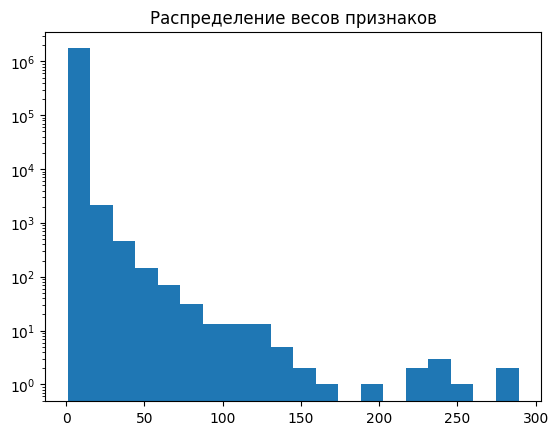

In [ ]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log');

### Распределение классов

In [ ]:
UNIQUE_LABELS_N = len(set(train_source['target']))
print('Количество уникальных меток', UNIQUE_LABELS_N)

Количество уникальных меток 20


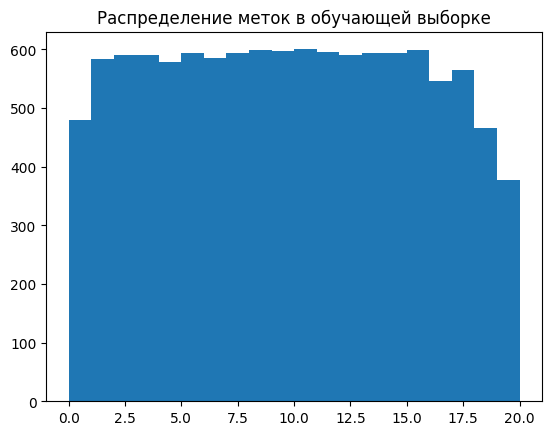

In [ ]:
plt.hist(train_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в обучающей выборке');

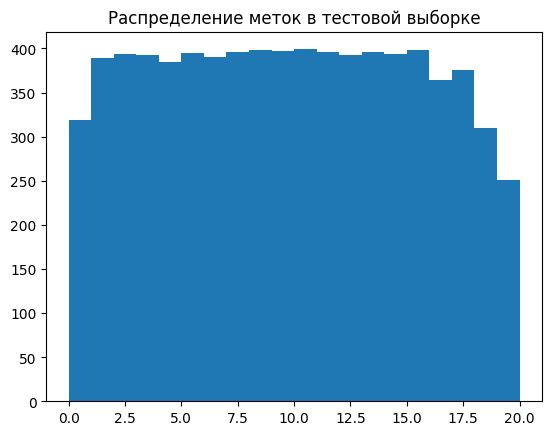

In [ ]:
plt.hist(test_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в тестовой выборке');

### PyTorch Dataset

Набор данных разреженных объектов

In [ ]:
train_dataset = SparseFeaturesDataset(train_vectors, train_source['target'])
test_dataset = SparseFeaturesDataset(test_vectors, test_source['target'])

## Обучение модели на PyTorch

Добавил регуляризацию L2 через параметр l2_reg_alpha в torch, что помогает избежать переобучения.
Регуляризация помогает предовратить переобучение, добавляя штраф за большие веса модели. Этот код более универсален за счет явного указания регуляризации параметром l2_reg_alpha

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

# Определяем модель
model = nn.Linear(num_unique_tokens, UNIQUE_LABELS_N)

# Регуляризация L2
l2_reg_alpha = 1e-4

# Конструктор планировщика обучения
scheduler = lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, verbose=True)

# Обучение модели
best_val_loss, best_model = train_eval_loop(
    model=model,
    train_dataset=train_dataset,
    val_dataset=test_dataset,
    criterion=F.cross_entropy,
    lr=1e-1,
    epoch_n=200,
    batch_size=32,
    l2_reg_alpha=l2_reg_alpha,
    lr_scheduler_ctor=scheduler
)

# Оценка на обучающей выборке
train_pred = predict_with_model(best_model, train_dataset)
train_loss = F.cross_entropy(torch.from_numpy(train_pred), torch.from_numpy(train_source['target']).long())

print('Среднее значение функции потерь на обучении', float(train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], train_pred.argmax(-1)))
print()

# Оценка на тестовой выборке
test_pred = predict_with_model(best_model, test_dataset)
test_loss = F.cross_entropy(torch.from_numpy(test_pred), torch.from_numpy(test_source['target']).long())

print('Среднее значение функции потерь на валидации', float(test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], test_pred.argmax(-1)))


Эпоха 0
Эпоха: 354 итераций, 7.42 сек
Среднее значение функции потерь на обучении 4.164166695696149
Среднее значение функции потерь на валидации 7.767792745161865
Новая лучшая модель!

Эпоха 1
Эпоха: 354 итераций, 7.05 сек
Среднее значение функции потерь на обучении 2.1106616048435654
Среднее значение функции потерь на валидации 6.363988975599661
Новая лучшая модель!

Эпоха 2
Эпоха: 354 итераций, 9.19 сек
Среднее значение функции потерь на обучении 1.553620043511394
Среднее значение функции потерь на валидации 6.33560788606183
Новая лучшая модель!

Эпоха 3
Эпоха: 354 итераций, 7.11 сек
Среднее значение функции потерь на обучении 1.5495880007529914
Среднее значение функции потерь на валидации 7.522075722783299

Эпоха 4
Эпоха: 354 итераций, 7.65 сек
Среднее значение функции потерь на обучении 2.107192566353027
Среднее значение функции потерь на валидации 8.125695136644072

Эпоха 5
Эпоха: 354 итераций, 6.49 сек
Среднее значение функции потерь на обучении 2.3354854245630388
Среднее значени

100%|██████████| 354/353.5625 [00:04<00:00, 84.13it/s]


Среднее значение функции потерь на обучении 0.019284220412373543
Доля верных ответов 0.9995580696482235



236it [00:02, 80.40it/s]

Среднее значение функции потерь на валидации 0.9020119905471802
Доля верных ответов 0.781465746149761


## Оценка качества

In [ ]:
train_pred = predict_with_model(best_model, train_dataset)

train_loss = F.cross_entropy(torch.from_numpy(train_pred),
                             torch.from_numpy(train_source['target']).long())

print('Среднее значение функции потерь на обучении', float(train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], train_pred.argmax(-1)))




test_pred = predict_with_model(best_model, test_dataset)

test_loss = F.cross_entropy(torch.from_numpy(test_pred),
                            torch.from_numpy(test_source['target']).long())

print('Среднее значение функции потерь на валидации', float(test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], test_pred.argmax(-1)))

100%|██████████| 354/353.5625 [00:09<00:00, 37.84it/s]


Среднее значение функции потерь на обучении 0.019284220412373543
Доля верных ответов 0.9995580696482235


236it [00:02, 92.15it/s]                             

Среднее значение функции потерь на валидации 0.9020119905471802
Доля верных ответов 0.781465746149761


# Альтернативная реализация на scikit-learn

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Создаем конвейер обработки данных и классификации
sklearn_pipeline = Pipeline((('vect', TfidfVectorizer(tokenizer=tokenize_text_simple_regex,
                                                      max_df=MAX_DF,
                                                      min_df=MIN_COUNT)),
                             ('cls', LogisticRegression())))
sklearn_pipeline.fit(train_source['data'], train_source['target']);

## Оценка качества

In [ ]:
sklearn_train_pred = sklearn_pipeline.predict_proba(train_source['data'])
sklearn_train_loss = F.cross_entropy(torch.from_numpy(sklearn_train_pred),
                                                 torch.from_numpy(train_source['target']))
print('Среднее значение функции потерь на обучении', float(sklearn_train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], sklearn_train_pred.argmax(-1)))
print()

sklearn_test_pred = sklearn_pipeline.predict_proba(test_source['data'])
sklearn_test_loss = F.cross_entropy(torch.from_numpy(sklearn_test_pred),
                                                torch.from_numpy(test_source['target']))
print('Среднее значение функции потерь на валидации', float(sklearn_test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], sklearn_test_pred.argmax(-1)))

Среднее значение функции потерь на обучении 2.4958095221795378
Доля верных ответов 0.9715396853455895

Среднее значение функции потерь на валидации 2.654061188404245
Доля верных ответов 0.8183749336165693


PMI (Pointwise Mutual Information) — это мера, которая оценивает, насколько часто два события (слово и документ) происходят вместе, по сравнению с их случайной совместной вероятностью

Размер словаря: 100, Точность на обучении: 0.0789, Точность на тесте: 0.0643
Размер словаря: 500, Точность на обучении: 0.1596, Точность на тесте: 0.1079
Размер словаря: 1000, Точность на обучении: 0.2500, Точность на тесте: 0.1390
Размер словаря: 5000, Точность на обучении: 0.7095, Точность на тесте: 0.3549
Размер словаря: 10000, Точность на обучении: 0.9172, Точность на тесте: 0.5262


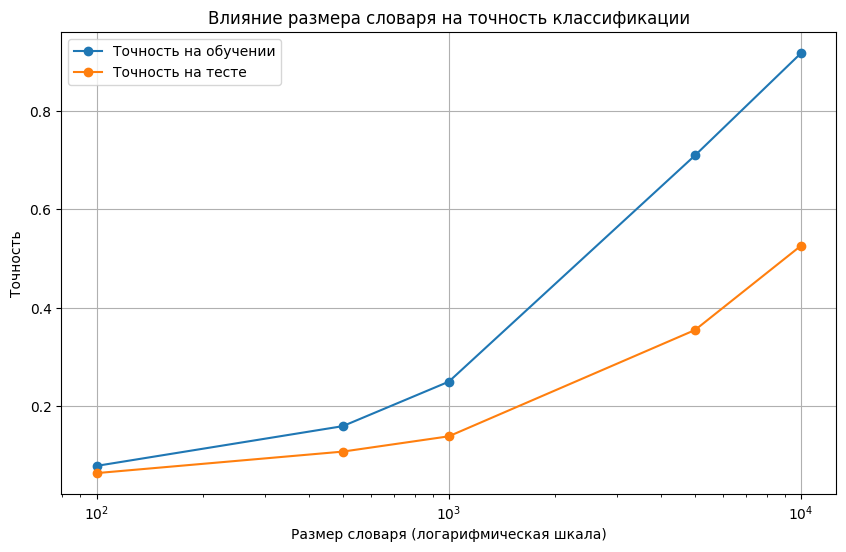

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
import numpy as np

# Функция для вычисления PMI
def compute_pmi(vocab, word_doc_freq, total_docs):
    pmi = {}
    for word, freq in vocab.items():
        p_w = freq / total_docs
        pmi[word] = np.log2(p_w) if p_w > 0 else 0
    return sorted(pmi.items(), key=lambda x: x[1], reverse=True)

# Вычисляем PMI для слов в словаре
total_docs = len(train_source['data'])
pmi_sorted_vocab = compute_pmi(vocabulary, word_doc_freq, total_docs)

# Функция для обучения модели и оценки качества
def train_and_evaluate_with_vocab_size(vocab_size):
    filtered_vocab = dict(pmi_sorted_vocab[:vocab_size]) # выбираем подмножество слов с наибольшими значениями PMI
    vectorizer = CountVectorizer(vocabulary=filtered_vocab.keys()) # По отобранным словам создается вектор чисел
    train_vectors = vectorizer.fit_transform(train_source['data']) # Преобразует обучающие данные в числовые векторы
    test_vectors = vectorizer.transform(test_source['data']) # Преобразует текстовые данные в числовые векторы

    model = LogisticRegression(max_iter=200) # Модель логистической регрессии, которая обучается на созданных векторах
    model.fit(train_vectors, train_source['target'])

    train_pred = model.predict(train_vectors) # Предсказание меток классов для обучающих данных
    test_pred = model.predict(test_vectors) # Предсказание меток классов для тестовых данных

    train_acc = accuracy_score(train_source['target'], train_pred) # Оценка точности классификации для обучающих данных
    test_acc = accuracy_score(test_source['target'], test_pred) # И для тестовых
    return train_acc, test_acc

# Анализируем качество классификации при разных размерах словаря
vocab_sizes = [100, 500, 1000, 5000, 10000]
results = {'vocab_size': [], 'train_acc': [], 'test_acc': []}

for size in vocab_sizes:
    train_acc, test_acc = train_and_evaluate_with_vocab_size(size)
    results['vocab_size'].append(size)
    results['train_acc'].append(train_acc)
    results['test_acc'].append(test_acc)
    print(f"Размер словаря: {size}, Точность на обучении: {train_acc:.4f}, Точность на тесте: {test_acc:.4f}")

# Визуализация зависимости качества от размера словаря
plt.figure(figsize=(10, 6))
plt.plot(results['vocab_size'], results['train_acc'], label='Точность на обучении', marker='o')
plt.plot(results['vocab_size'], results['test_acc'], label='Точность на тесте', marker='o')
plt.xscale('log')
plt.xlabel('Размер словаря (логарифмическая шкала)')
plt.ylabel('Точность')
plt.title('Влияние размера словаря на точность классификации')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(train_source['data'][0])  # Вывод первого текста из обучающей выборки
print('----------------------------------------------------------------------')
print(train_source['target'][0])  # Метка категории первого текста
print(train_source['target_names'][train_source['target'][0]])  # Название категории
print('----------------------------------------------------------------------')
print(list(vocabulary.items())[:50])  # Первые 10 слов словаря с их индексами
print('----------------------------------------------------------------------')
print(train_vectors.shape)  # Количество документов и слов
print('----------------------------------------------------------------------')
print(train_vectors[0].toarray())  # Вектор признаков для первого текста




From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





----------------------------------------------------------------------
7
rec.autos
----------------------------------------------------------------------
[('that', 0), ('this', 1), ('have', 2), ('with', 3), ('writes', 4), ('article', 5), ('posting', 6), ('host', 7), ('nntp', 8)

In [ ]:
from sklearn.datasets import fetch_20newsgroups

# Загружаем набор данных 20newsgroups
newsgroups = fetch_20newsgroups(subset='train')

# Тексты в поле data
texts = newsgroups.data

# Выводим все тексты
for i, text in enumerate(texts):
    print(f"Текст {i+1}:\n{text}\n")

Выходные данные были обрезаны до нескольких последних строк (5000).
OS Software Engineer    |
Thinking Machines Corp. |	the winged ninjas of the skies.
Cambridge, MA           |


Текст 11211:
From: koontzd@phobos.lrmsc.loral.com (David Koontz )
Subject: Spoofing Clipper Serial Number
Distribution: usa
Organization: Loral Rolm Mil-Spec Computers
Lines: 35

Secrecy in Clipper Chip

The serial number of the clipper chip is encrypted with the system key and
transmitted as one part of a three part message.

Presumably the protocol can be recovered (if by nothing else, differential
analysis).

Postulate if you will, a chip (or logic) sitting between the clipper chip
and its communications channel.  The purpose of this chip is twofold:
    
	1) Transmit Channel

	    The spoof chip XORs the 30 bit encrypted serial number with
	    a secondary keying variable.  This renders the serial number
	    unrecoverable with just the system key

	2) Recieve Channel

	    The spoof chip XORs the incomin

Вывод:

Этот код выполняет полный цикл от подготовки текстовых данных до оценки и сравнения моделей, позволяя анализировать влияние различных параметров (размер словаря, выбор метода векторизации и модели) на качество текстовой классификации.

Подробности:

1. Выбор метода векторизации текста

  а) TF-IDF и CountVectorizer:

  TF-IDF показывает более высокую точность на тесте (0.818) по сравнению с базовым CountVectorizer с ограниченным размером словаря.
  Важность метода векторизации: использование TF-IDF позволяет учитывать частотные особенности слов, что улучшает качество классификации.
  
  б) Словарь и PMI:

  Увеличение размера словаря значительно повышает точность. Например, с ростом словаря с 100 до 10,000 точность на тесте выросла с 0.064 до 0.526.


2. Выбор модели

  Логистическая регрессия vs. Нейронная сеть (Linear):

  Логистическая регрессия в сочетании с TF-IDF дает хорошую точность (0.818), но нейронная сеть показывает лучшие результаты на тесте (0.781 с меньшим loss), если используется обучение с L2-регуляризацией.

  Вывод: выбор модели зависит от сложности задачи и объема данных. Нейронная сеть может быть предпочтительнее для более сложных задач.


3. Гиперпараметры

  Регуляризация (L2):

  а) L2-регуляризация (параметр l2_reg_alpha) уменьшает переобучение, что особенно важно для моделей с большим количеством параметров.
  Без регуляризации модель могла бы показывать высокую точность на обучении, но низкую на тесте.

  б) Learning Rate (LR):

  Использование адаптивного планировщика (ReduceLROnPlateau) помогает оптимально изменять скорость обучения. Это важно для достижения минимального значения функции потерь.


4. Обучение и размер словаря

  Модели, работающие с уменьшенным словарем, дают плохие результаты (точность на тесте 0.064–0.526). Это связано с потерей информации из-за ограниченного размера словаря.

  При слишком большом словаре модель может переобучаться (высокая точность на обучении и низкая на тесте).


Итоги:

1. Методы векторизации: TF-IDF предпочтительнее для базовых классификаторов. CountVectorizer эффективен при достаточном размере словаря.
2. Регуляризация и оптимизация: Использование регуляризации и планировщиков скорости обучения способствует лучшему обобщению.
3. Модели: Нейронные сети имеют потенциал для лучшего результата, но требуют тщательной настройки.
4. Размер словаря: Важно находить баланс между достаточным количеством признаков и переобучением.